# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1967-1978. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1967, ..., 1978$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import chi2
import LinearModels as lm

# Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.lines import Line2D

plt.style.use('seaborn-whitegrid')
%matplotlib inline

plt.rc('font', size=10)             # controls default text sizes
plt.rc('axes', titlesize=12)        # fontsize of the axes title
plt.rc('axes', labelsize=12)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)       # fontsize of the tick labels
plt.rc('ytick', labelsize=11)       # fontsize of the tick labels
plt.rc('legend', fontsize=11)       # legend fontsize
plt.rc('figure', titlesize=15)      # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 4 # set default size of plots


C:\Users\JBH\AppData\Local\Temp\ipykernel_14736\1377799596.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
dat = pd.read_csv('firms.csv')

In [3]:
dat.to_stata('firms.dta')

In [4]:
dat

,firmid,year,lcap,lemp,ldsa
0,1,1967,1.039900,-0.270182,0.396948
1,1,1968,0.998602,-0.242185,0.349053
2,1,1969,0.925214,-0.241278,0.312492
3,1,1970,0.879616,-0.265134,0.347566
4,1,1971,0.843098,-0.317875,0.234744
...,...,...,...,...,...
5287,441,1974,-1.044260,-1.084540,-0.542948
5288,441,1975,-1.006080,-0.956662,-0.547157
5289,441,1976,-0.891433,-0.775592,-0.319247
5290,441,1977,-0.719267,-0.672649,-0.084397


In [5]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
813,68,1976,-0.077027,-0.300495,0.029443
2291,191,1978,-0.875423,-1.364070,-1.496630
1740,146,1967,-1.072880,-0.847661,-1.047250
3063,256,1970,-1.636990,-0.429869,-1.030610
204,18,1967,0.537630,0.185650,0.765757


In [6]:
dat.year.unique()

array([1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978], dtype=int64)

# Descriptives

In [7]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1972.500000,-2.379856e-08,-3.248299e-08,-4.440665e-10
std,127.317437,3.452379,1.323176e+00,1.187237e+00,1.234902e+00
min,1.000000,1967.000000,-4.033590e+00,-3.382780e+00,-3.554090e+00
25%,111.000000,1969.750000,-9.251980e-01,-8.001460e-01,-9.190837e-01
50%,221.000000,1972.500000,-1.083100e-01,-1.147060e-01,-1.105555e-01
75%,331.000000,1975.250000,9.307292e-01,7.973080e-01,8.622255e-01
max,441.000000,1978.000000,4.103687e+00,3.371332e+00,3.913391e+00


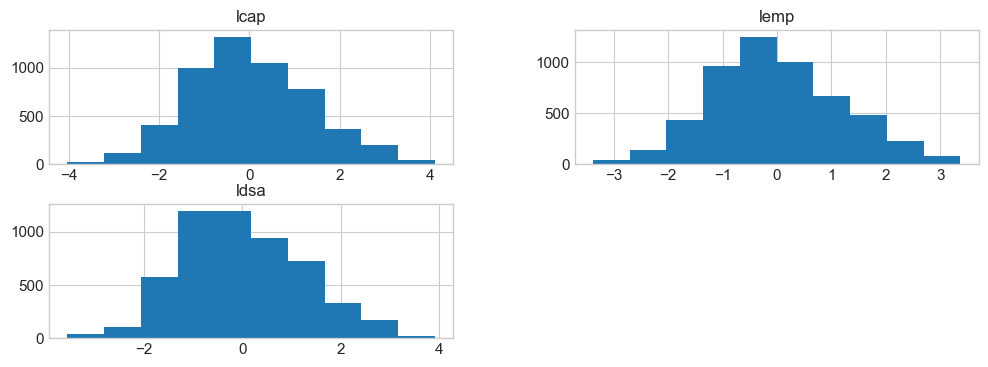

In [8]:
dat[['lcap','lemp','ldsa']].hist(); 

In [9]:
dat.year.unique().size

12

### Making a binned scatter to graphically assess for constant returns to scale

In [10]:
dat['total_input']=dat['lcap']+dat['lemp']

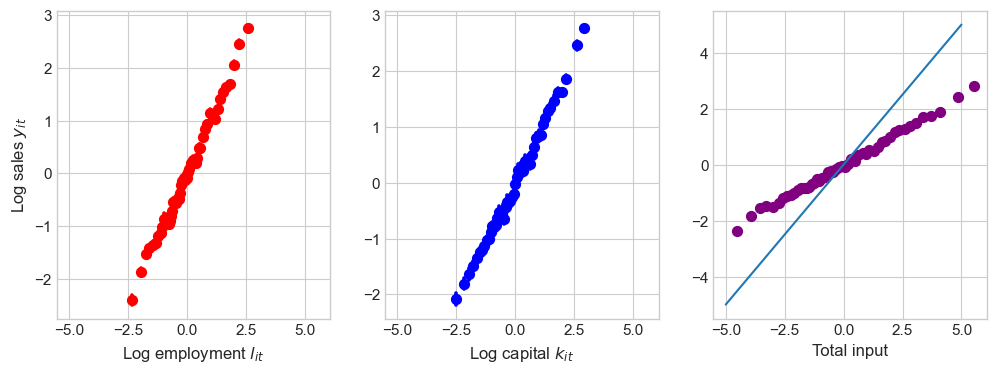

In [11]:
binplot, ax = plt.subplots(1,3, sharex=True)


sns.regplot(ax=ax[0], data=dat, y='ldsa', x='lemp', x_bins=50, color='red', fit_reg=False, ci=95)
ax[0].set_xlabel('Log employment $l_{it}$')
ax[0].set_ylabel('Log sales $y_{it}$')

sns.regplot(ax=ax[1], data=dat, y='ldsa', x='lcap', x_bins=50, color='blue', fit_reg=False, ci=95)
ax[1].set_xlabel('Log capital $k_{it}$')
ax[1].set_ylabel('')

sns.regplot(ax=ax[2], data=dat, y='ldsa', x='total_input', x_bins=50, color='purple', fit_reg=False, ci=95)
ax[2].set_xlabel('Total input')
ax[2].set_ylabel('')

straight_line = Line2D(ydata=np.array([-5,5]), xdata=np.array([-5,5]))

ax[2].add_line(straight_line)

plt.savefig('fig1.pdf', bbox_inches='tight')

# Converting data to numpy format 

In [12]:
dat.ldsa.values.shape

(5292,)

In [13]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


Extract data from `pandas` to `numpy` arrays. 

In [14]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([l, k])

clusters=dat.firmid.values.reshape(N*T, 1)

---

In [15]:
est_pols = lm.estimate(y,X, N=N, T=T)
label_y = 'Log of deflated sales'
label_x = ['Log employment', 'Log capital stock']

lm.print_table(labels=(label_y, label_x), results=est_pols, title='Pooled OLS', floatfmt='.4f')

Pooled OLS
Dependent variable: Log of deflated sales

                     Beta      Se    t-values
-----------------  ------  ------  ----------
Log employment     0.6778  0.0101     67.3336
Log capital stock  0.3028  0.0090     33.5190
R² = 0.914
σ² = 0.130
DF=5290
N=441
T=12


c:\Users\JBH\anaconda3\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


---

### FE-estimation

---

In [16]:
def demeaning_matrix(T):
    Q_T = np.eye(T)-np.tile(1/T,T)
    return Q_T

In [17]:
Q_T = demeaning_matrix(T)
y_demean = lm.perm(Q_T, y)
x_demean = lm.perm(Q_T,X)

In [18]:
x_demean.shape

(5292, 2)

In [19]:
#Checking the rank condition
lm.check_rank(x_demean)

'The matrix is of full rank with rank = 2'

In [20]:
label_x_fe = label_x
label_x_fe

['Log employment', 'Log capital stock']

In [21]:
est_fe = lm.estimate(y=y_demean, x=x_demean, transform='fe', T=T, N=N, se_type='robust')
lm.print_table(labels=(label_y, label_x_fe), results=est_fe, title='FE-estimation')

FE-estimation
Dependent variable: Log of deflated sales

                       Beta         Se    t-values
-----------------  --------  ---------  ----------
Log employment     0.696387  0.041808     16.6568
Log capital stock  0.142663  0.0281586     5.06642
R² = 0.492
σ² = 0.017
DF=4849
N=441
T=12


---

### FD-estimation

---

In [22]:
def fd_matrix(T):
    D_T = -np.eye(T)+np.eye(T, k=1)
    D_T = D_T[:-1, :]
    return D_T

D_T = fd_matrix(T)

y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T,X)
x_diff

lm.check_rank(x_diff)

'The matrix is of full rank with rank = 2'

In [23]:
x_label_fd = ['d.Log employment', 'd.Log capital stock']

est_fd = lm.estimate(y_diff, x_diff, transform='fd', T=T-1, N=N, se_type='robust')

lm.print_table((label_y, x_label_fd), est_fd, title='FD-estimation', floatfmt='.4f')

FD-estimation
Dependent variable: Log of deflated sales

                       Beta      Se    t-values
-------------------  ------  ------  ----------
d.Log employment     0.5462  0.0277     19.7080
d.Log capital stock  0.0645  0.0224      2.8836
R² = 0.174
σ² = 0.014
DF=4849
N=441
T=11


---

# Test for serial correlation 

---

### Sum up for requirements for efficiency and consistency (Wooldridge p.325)

**Estimate via FE**:

$$
y_{i t}=\mathbf{x}_{i t} \boldsymbol{\beta}+\mathbf{w}_{it+1} \boldsymbol{\delta}+c_i+u_{i t}
$$

Where  $\mathbf{w}_{it+1} \in \mathbf{x}_{it}$  

**Estimate via FD**

$$
\Delta y_{i t}=\Delta \mathbf{x}_{i t} \boldsymbol{\beta}+\mathbf{w}_{it} \boldsymbol{\gamma}+\Delta u_{i t}
$$

Where  $\mathbf{w}_{it} \in \mathbf{x}_{it}$  

|       | Efficiency                    | Consistency           |
--------|-------------------------------|--------------         |
|FD     | $corr(e_{it},e_{it-1})=0$  $(\rho=0)$   |    $\gamma=0$         |
|FE     | $corr(e_{it},e_{it-1})=-0.5$ $(\rho=-0.5)$   |    $\delta=0$         |

---

### Test for serial correlation (efficiency)

\begin{align}
    y_{it}=c_i+x_{it}\beta+u_{it}
\end{align}

\begin{align}
    e_{it}=\Delta u_{it}=u_{it}-u_{it-1}
\end{align}

$$
e_{it}=\rho e_{it-1}+error_{it}
$$

In [24]:
year = np.array(dat.year)

serial_corr = lm.serial_corr(y_diff, x_diff, T=T, N=N, year=year)

serial_corr_out =lm.outreg(serial_corr, var_labels=['$e_{t-1}$'], name='Serial Correlation')

print(pd.DataFrame(serial_corr_out)\
    .fillna('.')
    .rename(index={'se':'', 'beta':''})
    .to_latex(escape=False))

\begin{tabular}{lll}
\toprule
          & {} & Serial Correlation \\
\midrule
$e_{t-1}$ & {} &           -0.21*** \\
          & {} &            (0.015) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_14736\3470833868.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(serial_corr_out)\


![alt text](RandomWalkVsWhiteNoise.png "Title")

---

# Test for strict exogeneity

---

In [25]:
#We lead log employment + log capital +1
label_x_fe_lead = label_x_fe + ['Log employment +1', 'Log capital +1']

#We test for strict exogeneity
est_fe_exo = lm.strict_exo_FE(y=y, x=X, lead_var=np.hstack((l,k)), T=T, N=N, year=year)

fe_exo_out =lm.outreg(est_fe_exo, var_labels=label_x_fe_lead, name='Strict exogeneity test FE')

In [26]:
label_x_fd_exo = ['d.Log employment', 'd.Log capital stock', 'Log employment', 'Log capital stock']

est_fd_exo = lm.strict_exo_FD(y_diff=y_diff, x_diff=x_diff, w=np.hstack((l,k)), T=T, N=N, year=year)

fd_exo_out = lm.outreg(est_fd_exo, var_labels=label_x_fd_exo, name='Strict exogeneity test FD')

In [27]:
#Merge our series on left - play around with 'right', if it makes sense for our variables
table_exo = pd.merge(fe_exo_out, fd_exo_out, 'outer', left_index=True, right_index=True)
print(pd.DataFrame(data=table_exo)\
    .fillna('.')
    .rename(index={'se':'', 'beta':''})
    .to_latex())

\begin{tabular}{llll}
\toprule
                 & {} & Strict exogeneity test FE & Strict exogeneity test FD \\
\midrule
Log capital +1 & {} &                   0.17*** &                         . \\
                 & {} &                   (0.025) &                         . \\
Log capital stock & {} &                      0.01 &                    -0.01* \\
                 & {} &                   (0.022) &                   (0.003) \\
Log employment & {} &                   0.53*** &                      0.01 \\
                 & {} &                   (0.023) &                   (0.004) \\
Log employment +1 & {} &                   0.16*** &                         . \\
                 & {} &                   (0.022) &                         . \\
d.Log capital stock & {} &                         . &                   0.06*** \\
                 & {} &                         . &                   (0.018) \\
d.Log employment & {} &                         . &                 

C:\Users\JBH\AppData\Local\Temp\ipykernel_14736\1592223857.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data=table_exo)\


### Wald statistics

To compute a linear hypothesis of some (more than one) coefficients, define: 

\begin{align*}
(\mathbf{R} \widehat{\boldsymbol{\beta}}-\mathbf{R} \boldsymbol{\beta})^{\prime}\left[\mathbf{R}\underbrace{(\mathbf{V} / N)}_{\text{Asymptotic variance}} \mathbf{R}^{\prime}\right]^{-1}(\mathbf{R} \widehat{\boldsymbol{\beta}}-\mathbf{R} \boldsymbol{\beta}) \stackrel{d}{\approx} \chi_Q^2
\end{align*}

$Q=$ rank $(\mathbf{R})$. 

Under $\mathcal{H_0}$, $\mathbf{R\beta=r}$.

### Wald test of strict exogeneity FE/FD

**Estimate via FE**:

$$
ldsa_{i t}=\beta_1 lemp_{i t} +\beta_2 lcap_{i t}+ \beta_3lemp_{i t+1}+\beta_4lcap_{i t+1} + \ddot{u}_{i t}
$$



**Estimate via FD**

$$
\Delta ldsa_{i t}=\beta_1\Delta lemp_{i t} +\beta_2\Delta lcap_{i t}+ \beta_3lemp_{i t}+\beta_4lcap_{i t} +\Delta u_{i t}
$$

$\beta_3=\beta_4=0$


In [28]:
# We require the leaded (?) variables in FE to be equal to zero
# We require the non-differenced variable in FD to be equal to zero

R=np.eye(2)

wald_fd_exo = lm.wald_test(R=R, r=np.zeros(shape=(2,1)), beta_hat=est_fd_exo['b_hat'][2:], Avar=est_fd_exo['cov'][2:, 2:], label='FD')

wald_fe_exo = lm.wald_test(R=R, r=np.zeros(shape=(2,1)), beta_hat=est_fe_exo['b_hat'][2:], Avar=est_fe_exo['cov'][2:, 2:], label='FE')

exo_out = pd.merge(wald_fd_exo, wald_fe_exo, 'outer', left_index=True, right_index=True)

print(exo_out.to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &    FD &      FE \\
\midrule
p-value     &  0.14 &    0.00 \\
$\chi^2(2)$ &  3.97 &  103.54 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_14736\757751069.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(exo_out.to_latex(escape=False))


---

# Making latex table

---

Discard FE (and POLS), but land on FD (due to *not rejecting* null of no strict exogeneity). FD not efficient, though -> Use robust standard errors.

In [29]:
est_fd_robust = lm.estimate(y_diff, x_diff, transform='fd', T=T-1, N=N, se_type='robust')

In [48]:
series_pols = lm.outreg(est_pols, var_labels=label_x, name='POLS')
series_fe = lm.outreg(est_fe, var_labels=label_x_fe, name='FE')
series_fd = lm.outreg(est_fd, var_labels=x_label_fd, name='FD')

In [51]:
est_pols

{'b_hat': array([[0.67782694],
        [0.30275923]]),
 'se': array([[0.01006669],
        [0.00903247]]),
 'sigma': array([[0.13041198]]),
 't_values': array([[67.33362686],
        [33.51899686]]),
 'R2': array([[0.91449911]]),
 'cov': array([[ 1.01338304e-04, -8.27108250e-05],
        [-8.27108250e-05,  8.15854571e-05]]),
 'N': 441,
 'T': 12,
 'deg_of_frees': 5290}

In [49]:
#Merge our series on left - play around with 'right', if it makes sense for our variables
table1 = pd.merge(series_pols, series_fe, 'outer', left_index=True, right_index=True)
table1 = pd.merge(table1, series_fd, 'outer', left_index=True, right_index=True)

#Make our second index column empty for pretty latex table and fill NaN with '.', if not included in regression
print(table1\
    .fillna('.')
    .rename(index={'se':'', 'beta':''})
    .to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
                 & {} &     POLS &       FE &       FD \\
\midrule
Log capital stock & {} &   0.3*** &  0.14*** &        . \\
                 & {} &  (0.009) &  (0.028) &        . \\
Log employment & {} &  0.68*** &   0.7*** &        . \\
                 & {} &   (0.01) &  (0.042) &        . \\
d.Log capital stock & {} &        . &        . &   0.06** \\
                 & {} &        . &        . &  (0.022) \\
d.Log employment & {} &        . &        . &  0.55*** \\
                 & {} &        . &        . &  (0.028) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_14736\2023011785.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table1\


In [53]:
table1

POLS       FE       FD
Log capital stock   beta   0.3***  0.14***      NaN
                    se    (0.009)  (0.028)      NaN
Log employment      beta  0.68***   0.7***      NaN
                    se     (0.01)  (0.042)      NaN
d.Log capital stock beta      NaN      NaN   0.06**
                    se        NaN      NaN  (0.022)
d.Log employment    beta      NaN      NaN  0.55***
                    se        NaN      NaN  (0.028)

### Testing the hypothesis using FD

$\mathcal{H_0:}~\beta_l+\beta_k=1$ (Constant returns to scale)

$\mathcal{H_A:}~\beta_l+\beta_k\neq1$ (The one-sided alternative)

The test $\beta_l + \beta_k = 1$ corresponds to
$\mathbf{R}=\left[
    \begin{array}{ll}
    1 & 1 
    \end{array}\right]$ and $\mathbf{r=1}$.


In [32]:
R=np.array([[1,1]])
cons_re_to_scale = lm.wald_test(R=R, beta_hat=est_fd_robust['b_hat'], r=1, Avar=est_fd_robust['cov'])
print(cons_re_to_scale.to_latex(escape=False))

\begin{tabular}{lr}
\toprule
{} \\
\midrule
p-value     &    0.00 \\
$\chi^2(1)$ &  164.43 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_14736\107670655.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cons_re_to_scale.to_latex(escape=False))


# Addendum

Following code not included in assignment, just for sanity checks

---

### FE with time fixed effects

NB! From the assignment description, it seems that the cross-sectional mean has already been subtracted from the data. 
Makes no diff by including year dummies

---

In [33]:
ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
year = dat.year.values.reshape((N*T,1))
X_time_fe=np.hstack((ones,l,k,year))

In [34]:
dat.year.unique()

array([1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978], dtype=int64)

In [35]:
dummy = np.eye(T, k=-1) #For T=time periods 
dummy = dummy[: , :-1] #Rule out due to dummy trap
dummy_dummy = np.tile(dummy, (N,1))
print(dummy_dummy, '\n\n', dummy_dummy.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 

 (5292, 11)


In [36]:
#x_demean_time_dum = np.hstack((x_demean,dummy_dummy))

x_demean_time_dum = lm.perm(Q_T, X_time_fe)
x_demean_time_dum = x_demean_time_dum[:, 1:3:]
x_demean_time_dum = np.hstack((x_demean_time_dum, dummy_dummy))
#x_demean_time_dum = np.hstack((x_demean_time_dum[0, 1:], dummy_dummy))
label_x_fe_time = ['Log employment', 'Log capital stock', 
'1968', '1969', '1970', '1971', '1972', 
'1973', '1974', '1975', '1976', '1977', '1978']

In [37]:
x_demean_time_dum.shape

(5292, 13)

In [38]:
pd.DataFrame(x_demean_time_dum, columns=label_x_fe_time).head()

,Log employment,Log capital stock,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978
0,0.025516,0.135761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.053513,0.094463,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.054420,0.021075,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.030564,-0.024522,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.022177,-0.061041,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
lm.check_rank(x_demean_time_dum)

'The matrix is of full rank with rank = 13'

In [40]:
est_fe_time = lm.estimate(y=y_demean, x=x_demean_time_dum, transform='fe', T=T, N=N)
lm.print_table(labels=(label_y, label_x_fe_time), results=est_fe_time, title='Time FE estimation')

Time FE estimation
Dependent variable: Log of deflated sales

                           Beta          Se      t-values
-----------------  ------------  ----------  ------------
Log employment      0.696387     0.0144184   48.2986
Log capital stock   0.142663     0.012415    11.4912
1968               -1.024e-07    0.00630055  -1.62525e-05
1969                6.76665e-08  0.00630055   1.07398e-05
1970                5.92738e-08  0.00630055   9.40773e-06
1971               -9.89383e-08  0.00630055  -1.57031e-05
1972               -6.75207e-08  0.00630055  -1.07166e-05
1973               -1.73717e-07  0.00630055  -2.75718e-05
1974                1.36027e-07  0.00630055   2.15897e-05
1975                3.17182e-08  0.00630055   5.0342e-06
1976                6.68997e-08  0.00630055   1.06181e-05
1977                7.03834e-08  0.00630055   1.1171e-05
1978               -8.05727e-08  0.00630055  -1.27882e-05
R² = 0.492
σ² = 0.018
DF=4838
N=441
T=12


c:\Users\JBH\anaconda3\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


---

### Random effects 

Would not hold, as this assumes no corr between time-invariant unobservables $c_i$ (talent for example) and regressors.

---

### Between Estimator

In [41]:
def between_mat(T):
    P_T = np.tile(1/T, (1,T))
    return P_T
P_T = between_mat(T)

In [42]:
y_be = lm.perm(P_T, y)
x_be = lm.perm(P_T, X)
lm.check_rank(x_be)

'The matrix is of full rank with rank = 2'

In [43]:
est_be = lm.estimate(y=y_be, x=x_be, transform='be', T=T, N=N)
lm.print_table(labels=(label_y, label_x), results=est_be, title='BE-estimator')

BE-estimator
Dependent variable: Log of deflated sales

                       Beta         Se    t-values
-----------------  --------  ---------  ----------
Log employment     0.669482  0.0339893     19.6969
Log capital stock  0.312461  0.03052       10.2379
R² = 0.924
σ² = 0.114
DF=439
N=441
T=12


In [44]:
from math import sqrt

sigma2_u = est_fe['sigma'] # fill in
sigma2_c = est_be['sigma']-1/T*est_fe['sigma'] # fill in
_lambda = 1-sqrt(sigma2_u/(sigma2_u+T*sigma2_c)) # fill in
print(_lambda)

0.8870561237521509


Since we have to use $\hat{\lambda}$ to quasi-demean within each individual, we again use the `perm` function. This time, we pass it the following transformation matrix,

$$
\mathbf{C}_{T}:=\mathbf{I}_{T} - \hat{\lambda}\mathbf{P}_{T},
$$

where $\mathbf{P}_{T}$ is the $1 \times T$ transformation vector we used earlier to calculate the mean of each person.

In [45]:
def quasi_demean_mat(T, _lambda):
    P_T = between_mat(T)
    C_T = np.eye(T)-_lambda*P_T
    return C_T
C_T = quasi_demean_mat(T, _lambda)

In [46]:
y_re = lm.perm(C_T, y)
x_re = lm.perm(C_T, X) 
lm.check_rank(x_re)

'The matrix is of full rank with rank = 2'

In [47]:
est_re = lm.estimate(y=y_re, x=x_re, transform='re', T=T, N=N)
print(lm.print_table(labels=(label_y, label_x), results=est_re), 'lambda=',_lambda)

Results
Dependent variable: Log of deflated sales

                       Beta         Se    t-values
-----------------  --------  ---------  ----------
Log employment     0.723473  0.0129028     56.0711
Log capital stock  0.185219  0.0113045     16.3846
R² = 0.649
σ² = 0.018
DF=5290
N=441
T=12
None lambda= 0.8870561237521509
